In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.core.display import display, HTML
%matplotlib inline

In [2]:
import geopandas as gpd
import geocoder
import folium
import requests
import time
import math

In [3]:
from shapely.geometry import Point

In [4]:
# Notebook Styling 
# sns.set()
pd.options.display.max_columns = None
display(HTML("<style>.container { width:100% !important; }</style>"))

The data set below is available on this [City of Chicago Data Portal page](https://data.cityofchicago.org/Public-Safety/Crimes-2001-to-present/ijzp-q8t2), but as the file is approximately 1 GB, I've excluded it from this repo.

[Chicago Community Area Geojson](https://data.cityofchicago.org/Facilities-Geographic-Boundaries/Boundaries-Community-Areas-current-/cauq-8yn6)

[Chicago Police Beat Geojson](https://data.cityofchicago.org/Public-Safety/Boundaries-Police-Beats-current-/aerh-rz74)

[Chicago 2010 Census Block Geojson](https://data.cityofchicago.org/Facilities-Geographic-Boundaries/Boundaries-Census-Blocks-2010/mfzt-js4n)

In [6]:
keep_cols = ['Case Number', 'Date', 'Block', 'IUCR', 'Primary Type', 'Description', 'Location Description', 'Arrest', 
             'Domestic', 'Beat', 'District', 'Ward', 'Community Area', 'Year', 'Updated On', 'Latitude', 'Longitude']

CSV_PATH = os.path.join('data', 'big', 'Crimes_-_2001_to_present.csv')
crime_dtypes = {'District':str,
                'Ward':str, 
                'Community Area':str}
chi_crimes = pd.read_csv(CSV_PATH, usecols=keep_cols, dtype=crime_dtypes, encoding='latin1') 

,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,Ward,Community Area,Year,Updated On,Latitude,Longitude
0,JA366925,01/01/2001 11:00:00 AM,016XX E 86TH PL,1153,DECEPTIVE PRACTICE,FINANCIAL IDENTITY THEFT OVER $ 300,RESIDENCE,False,False,412,004,8,45,2001,08/05/2017 03:50:08 PM,NaN,NaN
1,JB147188,10/08/2017 03:00:00 AM,092XX S RACINE AVE,0281,CRIM SEXUAL ASSAULT,NON-AGGRAVATED,RESIDENCE,False,False,2222,022,21,73,2017,02/11/2018 03:57:41 PM,NaN,NaN
2,JB147595,03/28/2017 02:00:00 PM,026XX W 79TH ST,0620,BURGLARY,UNLAWFUL ENTRY,OTHER,False,False,835,008,18,70,2017,02/11/2018 03:57:41 PM,NaN,NaN
3,JB147230,09/09/2017 08:17:00 PM,060XX S EBERHART AVE,0810,THEFT,OVER $500,RESIDENCE,False,False,313,003,20,42,2017,02/11/2018 03:57:41 PM,NaN,NaN
4,JB147599,08/26/2017 10:00:00 AM,001XX W RANDOLPH ST,0281,CRIM SEXUAL ASSAULT,NON-AGGRAVATED,HOTEL/MOTEL,False,False,122,001,42,32,2017,02/11/2018 03:57:41 PM,NaN,NaN


In [ ]:
chi_crimes.head(3)

In [8]:
print(f"Crimes without a latitude value:  {chi_crimes['Latitude'].isnull().sum()}")
print(f"Crimes without a longitude value: {chi_crimes['Longitude'].isnull().sum()}")

Crimes without a latitude value:  66635
Crimes without a longitude value: 66635


In [9]:
date_pattern = '%m/%d/%Y %I:%M:%S %p'
chi_crimes['Date'] = pd.to_datetime(chi_crimes['Date'], format=date_pattern)
chi_crimes['Updated On'] = pd.to_datetime(chi_crimes['Updated On'], format=date_pattern)

In [16]:
chi_crimes_recent = chi_crimes.loc[(chi_crimes['Case Number'].str[0] == 'J') | (chi_crimes['Date'] >= '2016-01-01')].copy()

In [17]:
chi_crimes_recent['geometry'] = chi_crimes_recent.apply(lambda x: Point(x['Longitude'], x['Latitude']), axis=1)

In [18]:
chi_crimes_recent = gpd.GeoDataFrame(chi_crimes_recent, crs={'init': 'epsg:4326'}, geometry=chi_crimes_recent['geometry'])

In [19]:
# EPSG 3857 is in units of meters
chi_crimes_recent['geometry'] = chi_crimes_recent['geometry'].to_crs(epsg=3857)

In [20]:
chi_crimes_recent.head(2)

,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,Ward,Community Area,Year,Updated On,Latitude,Longitude,geometry
0,JA366925,2001-01-01 11:00:00,016XX E 86TH PL,1153,DECEPTIVE PRACTICE,FINANCIAL IDENTITY THEFT OVER $ 300,RESIDENCE,False,False,412,004,8,45,2001,2017-08-05 15:50:08,NaN,NaN,POINT (nan nan)
1,JB147188,2017-10-08 03:00:00,092XX S RACINE AVE,0281,CRIM SEXUAL ASSAULT,NON-AGGRAVATED,RESIDENCE,False,False,2222,022,21,73,2017,2018-02-11 15:57:41,NaN,NaN,POINT (nan nan)


In [21]:
chi_crimes_recent.loc[:,'Primary Type'].value_counts()

THEFT                                240809
BATTERY                              189603
CRIMINAL DAMAGE                      109575
ASSAULT                               75314
DECEPTIVE PRACTICE                    73838
OTHER OFFENSE                         65384
NARCOTICS                             49709
BURGLARY                              46662
MOTOR VEHICLE THEFT                   39858
ROBBERY                               39791
CRIMINAL TRESPASS                     25562
WEAPONS VIOLATION                     18769
OFFENSE INVOLVING CHILDREN             9369
CRIM SEXUAL ASSAULT                    6499
PUBLIC PEACE VIOLATION                 5767
INTERFERENCE WITH PUBLIC OFFICER       4624
SEX OFFENSE                            4382
PROSTITUTION                           2796
HOMICIDE                               2470
ARSON                                  1629
LIQUOR LAW VIOLATION                    880
STALKING                                757
GAMBLING                        

In [23]:
chi_crimes_recent.loc[chi_crimes_recent['Primary Type'] == 'HOMICIDE', 'Description'].value_counts()

FIRST DEGREE MURDER    2445
RECKLESS HOMICIDE        25
Name: Description, dtype: int64

In [22]:
chi_crimes_recent.loc[chi_crimes_recent['Primary Type'] == 'BATTERY', 'Description'].value_counts()

DOMESTIC BATTERY SIMPLE                                        91950
SIMPLE                                                         61805
AGGRAVATED: HANDGUN                                             7816
AGGRAVATED: OTHER DANG WEAPON                                   7100
AGGRAVATED DOMESTIC BATTERY: OTHER DANG WEAPON                  4372
AGGRAVATED:KNIFE/CUTTING INSTR                                  3358
AGGRAVATED DOMESTIC BATTERY: KNIFE/CUTTING INST                 2835
PRO EMP HANDS NO/MIN INJURY                                     2762
AGG PO HANDS NO/MIN INJURY                                      2344
AGGRAVATED DOMESTIC BATTERY: HANDS/FIST/FEET SERIOUS INJURY     1971
AGGRAVATED OF A SENIOR CITIZEN                                   852
AGG: HANDS/FIST/FEET NO/MINOR INJURY                             661
AGG: HANDS/FIST/FEET SERIOUS INJURY                              582
AGGRAVATED OF A CHILD                                            266
AGGRAVATED PO: OTHER DANG WEAP    

**IUCR** (Illinois Uniform Crime Reporting) codes indicate the nature of the crime. Non-fatal shootings will of of the class "aggravated battery" and will have an IUCR code from the set [041A, 041B, 0450, 0451, 0488, 0489]. Homicides have IUCR code 0110.

In [27]:
chi_crimes_recent.loc[chi_crimes_recent['Primary Type'] == 'BATTERY', ['Description', 'IUCR']].drop_duplicates().sort_values('IUCR')

,Description,IUCR
64305,AGGRAVATED: HANDGUN,041A
69495,AGGRAVATED: OTHER FIREARM,041B
60445,AGGRAVATED:KNIFE/CUTTING INSTR,0420
27288,AGGRAVATED: OTHER DANG WEAPON,0430
63572,AGG: HANDS/FIST/FEET NO/MINOR INJURY,0440
98552,AGGRAVATED PO: HANDGUN,0450
134452,AGGRAVATED PO: OTHER FIREARM,0451
83848,AGGRAVATED PO: KNIFE/CUT INSTR,0452
64417,AGGRAVATED PO: OTHER DANG WEAP,0453
64245,AGG PO HANDS NO/MIN INJURY,0454


In [29]:
shootings = chi_crimes_recent.loc[chi_crimes_recent['IUCR'].isin(['041A', '041B', '0450', '0451', '0488', '0489'])].copy()

In [31]:
shootings.head()

,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,Ward,Community Area,Year,Updated On,Latitude,Longitude,geometry
64305,JA486531,2017-10-26 11:05:00,041XX S MICHIGAN AVE,041A,BATTERY,AGGRAVATED: HANDGUN,ALLEY,True,False,213,002,3,38,2017,2019-06-04 16:01:14,41.819549,-87.623109,POINT (-9754159.890 5133986.946)
64320,JB496541,2018-10-30 16:59:00,040XX W 30TH ST,041A,BATTERY,AGGRAVATED: HANDGUN,SIDEWALK,True,False,1031,010,22,30,2018,2019-06-04 16:01:14,41.838706,-87.725954,POINT (-9765608.549 5136848.990)
64552,JA549380,2017-12-14 18:09:00,065XX S GREEN ST,041A,BATTERY,AGGRAVATED: HANDGUN,SIDEWALK,False,False,723,007,6,68,2017,2019-06-06 16:02:57,41.775378,-87.645890,POINT (-9756695.874 5127391.356)
64572,JC191684,2019-03-19 15:15:00,053XX S MARSHFIELD AVE,041A,BATTERY,AGGRAVATED: HANDGUN,STREET,True,False,932,009,16,61,2019,2019-06-06 16:02:57,41.797206,-87.665882,POINT (-9758921.399 5130650.158)
64680,JB333435,2018-07-03 11:15:00,106XX S LOWE AVE,041A,BATTERY,AGGRAVATED: HANDGUN,ALLEY,True,False,2233,022,34,49,2018,2019-06-07 15:58:09,41.700788,-87.639003,POINT (-9755929.154 5116263.727)


In [37]:
ZIP_SHP_PATH = os.path.join('zip://', 'data_raw', 'CTA_RailStations.zip')
cta_stops = gpd.read_file(ZIP_SHP_PATH)
cta_stops['geometry'] = cta_stops['geometry'].to_crs(epsg=3857)

In [72]:
ZIP_SHP_PATH = os.path.join('zip://', 'data', 'Boundaries - City.zip')
chicago = gpd.read_file(ZIP_SHP_PATH)
chicago['geometry'] = chicago['geometry'].to_crs(epsg=3857)

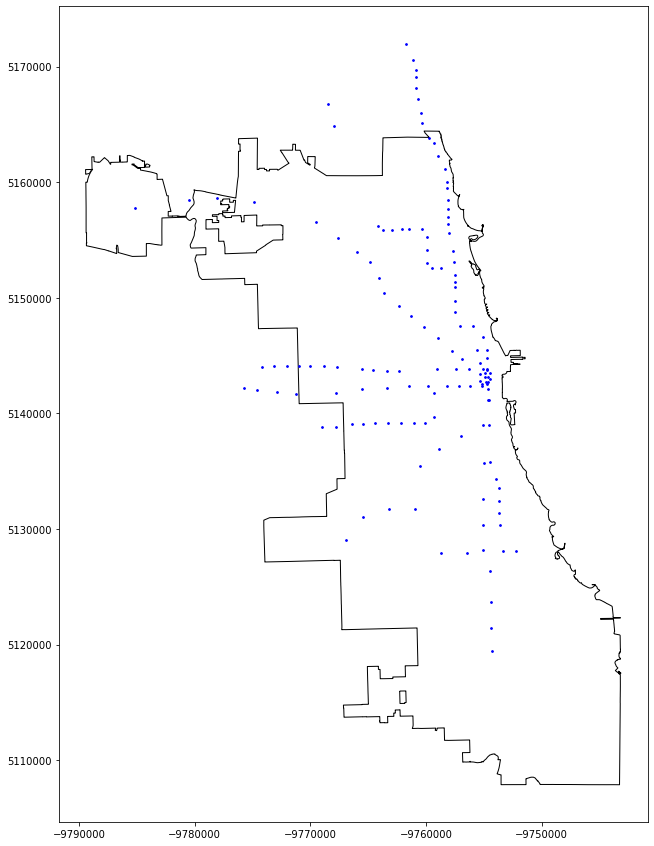

In [73]:
base = chicago.plot(color='white', edgecolor='black', figsize=(15,15))
cta_stops.plot(ax=base, markersize=3, color='blue')

In [39]:
cta_stops.head()

,STATION_ID,LONGNAME,LINES,ADDRESS,ADA,PKNRD,POINT_X,POINT_Y,GTFS,geometry
0,1120,35-Bronzeville-IIT,Green Line,16 E. 35th Street,1,0,1.177051e+06,1.882048e+06,41120,POINT (-9754468.506 5135798.881)
1,760,Granville,Red Line,1119 W. Granville Avenue,1,0,1.167506e+06,1.941003e+06,40760,POINT (-9758177.761 5160030.428)
2,1210,Wellington,"Brown, Purple (Express)",945 W. Wellington Avenue,1,0,1.169286e+06,1.920014e+06,41210,POINT (-9757516.988 5151402.249)
3,140,Dempster-Skokie,Yellow Line,5001 W. Dempster Street,1,1,1.142190e+06,1.957320e+06,40140,POINT (-9768498.898 5166815.856)
4,370,Washington/Dearborn,Blue Line,19 N. Dearborn,0,0,1.175927e+06,1.900801e+06,40370,POINT (-9754864.646 5143494.077)


In [40]:
def min_distance(point, points):
    return points.distance(point).min()

That distance is in meters.

In [43]:
shootings['meters_to_nearest_cta_stop'] = shootings['geometry'].apply(min_distance, args=(cta_stops,))

In [44]:
shootings.head()

,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,Ward,Community Area,Year,Updated On,Latitude,Longitude,geometry,min_dist_to_cta_stop,meters_to_nearest_cta_stop
64305,JA486531,2017-10-26 11:05:00,041XX S MICHIGAN AVE,041A,BATTERY,AGGRAVATED: HANDGUN,ALLEY,True,False,213,002,3,38,2017,2019-06-04 16:01:14,41.819549,-87.623109,POINT (-9754159.890 5133986.946),384.959206,384.959206
64320,JB496541,2018-10-30 16:59:00,040XX W 30TH ST,041A,BATTERY,AGGRAVATED: HANDGUN,SIDEWALK,True,False,1031,010,22,30,2018,2019-06-04 16:01:14,41.838706,-87.725954,POINT (-9765608.549 5136848.990),2271.229463,2271.229463
64552,JA549380,2017-12-14 18:09:00,065XX S GREEN ST,041A,BATTERY,AGGRAVATED: HANDGUN,SIDEWALK,False,False,723,007,6,68,2017,2019-06-06 16:02:57,41.775378,-87.645890,POINT (-9756695.874 5127391.356),583.094284,583.094284
64572,JC191684,2019-03-19 15:15:00,053XX S MARSHFIELD AVE,041A,BATTERY,AGGRAVATED: HANDGUN,STREET,True,False,932,009,16,61,2019,2019-06-06 16:02:57,41.797206,-87.665882,POINT (-9758921.399 5130650.158),2311.623666,2311.623666
64680,JB333435,2018-07-03 11:15:00,106XX S LOWE AVE,041A,BATTERY,AGGRAVATED: HANDGUN,ALLEY,True,False,2233,022,34,49,2018,2019-06-07 15:58:09,41.700788,-87.639003,POINT (-9755929.154 5116263.727),3605.674525,3605.674525


## Vacant Building Feature Engineering

In [45]:
CSV_PATH = os.path.join('data', 'Vacant_and_Abandoned_Buildings_-_Violations.csv')
vacant_buildings = pd.read_csv(CSV_PATH) 

In [47]:
date_pattern = '%m/%d/%Y'
vacant_buildings['Issued Date'] = pd.to_datetime(vacant_buildings['Issued Date'], format=date_pattern)

In [49]:
vacant_buildings.head(2)

,Docket Number,Violation Number,Issued Date,Issuing Department,Last Hearing Date,Property Address,Violation Type,Entity or Person(s),Disposition Description,Total Fines,Total Administrative Costs,Interest Amount,Collection Costs or Attorney Fees,Court Cost,Original Total Amount Due,Total Paid,Current Amount Due
0,11BS02904A,11DR286648,2011-03-31,BLDINGS,05/12/2011 12:00:00 PM,6738 S KOLIN,193110 Insure and secure vacant building. (13-...,FEDERAL NATIONAL MORTGAGE ASSN NATIONAL PROPER...,Not liable - Respondent came into compliance w...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN
1,11BS04331A,11N0295731,2011-05-28,BLDINGS,07/12/2011 12:00:00 PM,3563 W MC LEAN,193105 Register and secure vacant building. (1...,"US BANK, NA C/O JEANNE ESCOBEDO, TRUST LEGAL D...",Not liable - City failed to establish prima fa...,2000.0,0.0,0.0,0.0,NaN,0.0,0.0,2053.17


In [50]:
vacant_buildings['Property Address'].nunique()

2387

In [51]:
class GeoSessions:
    def __init__(self):
        self.Arcgis = requests.Session()
        self.Komoot = requests.Session()
        self.USCensus = requests.Session()
        self.OSM = requests.Session()

def create_sessions():
    return GeoSessions()

def geocode_address(address, s):
    g = geocoder.arcgis(address, session=s.Arcgis)
    if (g.ok == False):
        g = geocoder.komoot(address, session=s.Komoot)
    if (g.ok == False):
        g = geocoder.osm(address, session=s.OSM)        
    if (g.ok == False):
        g = geocoder.uscensus(address, session=s.USCensus)
    return g

In [67]:
addrs_df = pd.DataFrame(list(vacant_buildings['Property Address'].unique()))
addrs_df.rename({0:'Address'}, inplace=True, axis=1)

In [68]:
addrs_df['Address'] = addrs_df['Address'] + ', Chicago, IL'
addrs_df['Latitude'] = np.nan
addrs_df['Longitude'] = np.nan

In [66]:
OUT_PATH = os.path.join('data', 'geocoded_vacant_buildings.csv')
if os.path.isfile(OUT_PATH):
    addrs_df = pd.read_csv(OUT_PATH)
    print('It existed')
addrs_df.head()

,Address,Latitude,Longitude
0,"6738 S KOLIN , Chicago, IL",NaN,NaN
1,"3563 W MC LEAN , Chicago, IL",NaN,NaN
2,"3330 W 58TH , Chicago, IL",NaN,NaN
3,"5758 S CHRISTIANA , Chicago, IL",NaN,NaN
4,"444 E 89TH , Chicago, IL",NaN,NaN


In [69]:
s = create_sessions()

In [70]:
failed_inds = []
iterations_between_saves = 100

In [71]:
missing_latlong_indices = addrs_df[addrs_df['Latitude'].isnull()][:2501].index.tolist()

for i in missing_latlong_indices:
    try:
        if i%iterations_between_saves == 0:
            print('reached index {}, saving df'.format(i))
            addrs_df.to_csv(OUT_PATH, index=False)
        addr = addrs_df['Address'][i]
        tmp = geocode_address(addr, s)
        addrs_df.loc[i,'Latitude'] = tmp.lat
        addrs_df.loc[i,'Longitude'] = tmp.lng
    except Exception as e:
        failed_inds.append(i)
addrs_df.to_csv(OUT_PATH, index=False)

reached index 0, saving df
reached index 100, saving df
reached index 200, saving df
reached index 300, saving df
reached index 400, saving df
reached index 500, saving df
reached index 600, saving df
reached index 700, saving df
reached index 800, saving df
reached index 900, saving df
reached index 1000, saving df
reached index 1100, saving df
reached index 1200, saving df
reached index 1300, saving df
reached index 1400, saving df
reached index 1500, saving df
reached index 1600, saving df
reached index 1700, saving df
reached index 1800, saving df
reached index 1900, saving df
reached index 2000, saving df
reached index 2100, saving df
reached index 2200, saving df
reached index 2300, saving df


In [78]:
addrs_df['Join_Address'] = addrs_df['Address'].str.replace(', Chicago, IL', '')

In [80]:
vacant_buildings_df = pd.merge(left=vacant_buildings, right=addrs_df, how='left', left_on='Property Address', right_on='Join_Address')

In [83]:
vacant_buildings_df.head(2)

,Docket Number,Violation Number,Issued Date,Issuing Department,Last Hearing Date,Property Address,Violation Type,Entity or Person(s),Disposition Description,Total Fines,Total Administrative Costs,Interest Amount,Collection Costs or Attorney Fees,Court Cost,Original Total Amount Due,Total Paid,Current Amount Due,Address,Latitude,Longitude,Join_Address
0,11BS02904A,11DR286648,2011-03-31,BLDINGS,05/12/2011 12:00:00 PM,6738 S KOLIN,193110 Insure and secure vacant building. (13-...,FEDERAL NATIONAL MORTGAGE ASSN NATIONAL PROPER...,Not liable - Respondent came into compliance w...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,"6738 S KOLIN , Chicago, IL",41.770093,-87.731085,6738 S KOLIN
1,11BS04331A,11N0295731,2011-05-28,BLDINGS,07/12/2011 12:00:00 PM,3563 W MC LEAN,193105 Register and secure vacant building. (1...,"US BANK, NA C/O JEANNE ESCOBEDO, TRUST LEGAL D...",Not liable - City failed to establish prima fa...,2000.0,0.0,0.0,0.0,NaN,0.0,0.0,2053.17,"3563 W MC LEAN , Chicago, IL",41.918182,-87.715991,3563 W MC LEAN


In [82]:
type(vacant_buildings_df)

pandas.core.frame.DataFrame

In [84]:
vacant_buildings_df['geometry'] = vacant_buildings_df.apply(lambda x: Point(x['Longitude'], x['Latitude']), axis=1)
vacant_buildings_df = gpd.GeoDataFrame(vacant_buildings_df, crs={'init': 'epsg:4326'}, geometry=vacant_buildings_df['geometry'])
vacant_buildings_df['geometry'] = vacant_buildings_df['geometry'].to_crs(epsg=3857)

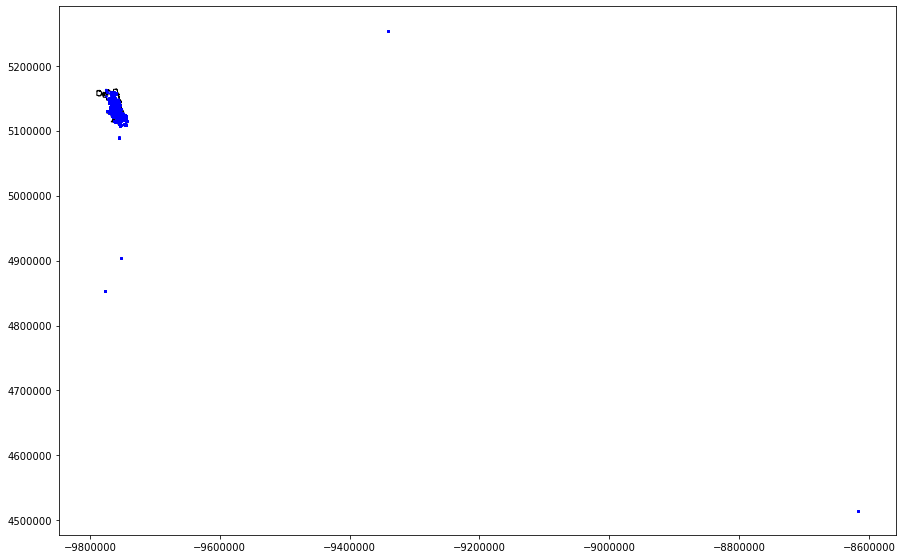

In [85]:
base = chicago.plot(color='white', edgecolor='black', figsize=(15,15))
vacant_buildings_df.plot(ax=base, markersize=3, color='blue')

Ok, so there are some addresses that didn't geocode well.

In [86]:
chicago_bounds = chicago['geometry'].unary_union

In [87]:
outside_chicago = vacant_buildings_df[~vacant_buildings_df['geometry'].within(chicago_bounds)]

In [88]:
outside_chicago

,Docket Number,Violation Number,Issued Date,Issuing Department,Last Hearing Date,Property Address,Violation Type,Entity or Person(s),Disposition Description,Total Fines,Total Administrative Costs,Interest Amount,Collection Costs or Attorney Fees,Court Cost,Original Total Amount Due,Total Paid,Current Amount Due,Address,Latitude,Longitude,Join_Address,geometry
1116,11CP045537,P003017198,2011-08-03,POLICE,10/07/2011 09:00:00 AM,433 S UNION,13-12-140 Watchman required,"BANK NY MELLON,",City non-suit,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,"433 S UNION , Chicago, IL",41.522424,-87.633221,433 S UNION,POINT (-9755285.574 5089707.185)
1118,11CP045537,P003017199,2011-08-03,POLICE,10/07/2011 09:00:00 AM,433 S UNION,13-12-140 Watchman required,"BANK NY MELLON,",City non-suit,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,"433 S UNION , Chicago, IL",41.522424,-87.633221,433 S UNION,POINT (-9755285.574 5089707.185)
1120,11CP045537,P003017200,2011-08-03,POLICE,10/07/2011 09:00:00 AM,433 S UNION,13-12-140 Watchman required,"BANK NY MELLON,",City non-suit,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,"433 S UNION , Chicago, IL",41.522424,-87.633221,433 S UNION,POINT (-9755285.574 5089707.185)
1801,11CP071396,P003060476,2011-10-20,POLICE,02/03/2012 01:00:00 AM,100 UNKNOWN,13-12-125 Duty to secure and maintain vacant ...,"METROPOLITAN BANK,",City non-suit,0.0,0.0,0.0,0.0,NaN,0.0,0.0,40.0,"100 UNKNOWN , Chicago, IL",39.909539,-87.822795,100 UNKNOWN,POINT (-9776388.804 4852805.421)
1803,11CP071396,P003060477,2011-10-20,POLICE,02/03/2012 01:00:00 AM,100 UNKNOWN,13-12-140 Watchman required,"METROPOLITAN BANK,",City non-suit,0.0,0.0,0.0,0.0,NaN,0.0,0.0,40.0,"100 UNKNOWN , Chicago, IL",39.909539,-87.822795,100 UNKNOWN,POINT (-9776388.804 4852805.421)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19546,17CP091273,P005238194,2017-09-14,POLICE,11/03/2017 11:00:00 AM,100 UNKNOWN,13-12-125 Duty to secure and maintain vacant ...,"U S BANK NATIONAL,",City non-suit,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,"100 UNKNOWN , Chicago, IL",39.909539,-87.822795,100 UNKNOWN,POINT (-9776388.804 4852805.421)
19548,17CP091273,P005238195,2017-09-14,POLICE,11/03/2017 11:00:00 AM,100 UNKNOWN,13-12-140 Watchman required,"U S BANK NATIONAL,",City non-suit,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,"100 UNKNOWN , Chicago, IL",39.909539,-87.822795,100 UNKNOWN,POINT (-9776388.804 4852805.421)
19550,17CP091273,P005238196,2017-09-14,POLICE,11/03/2017 11:00:00 AM,100 UNKNOWN,13-12-125 Duty to secure and maintain vacant ...,"U S BANK NATIONAL,",City non-suit,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,"100 UNKNOWN , Chicago, IL",39.909539,-87.822795,100 UNKNOWN,POINT (-9776388.804 4852805.421)
19552,17CP091273,P005238197,2017-09-14,POLICE,11/03/2017 11:00:00 AM,100 UNKNOWN,13-12-140 Watchman required,"U S BANK NATIONAL,",City non-suit,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,"100 UNKNOWN , Chicago, IL",39.909539,-87.822795,100 UNKNOWN,POINT (-9776388.804 4852805.421)


Ok, that makes sense. The majority of the incorrectly geocoded addresses had the address "100 UNKNOWN". So it makes sense that they produced garbage.

In [89]:
vacant_in_chicago = vacant_buildings_df[vacant_buildings_df['geometry'].within(chicago_bounds)]

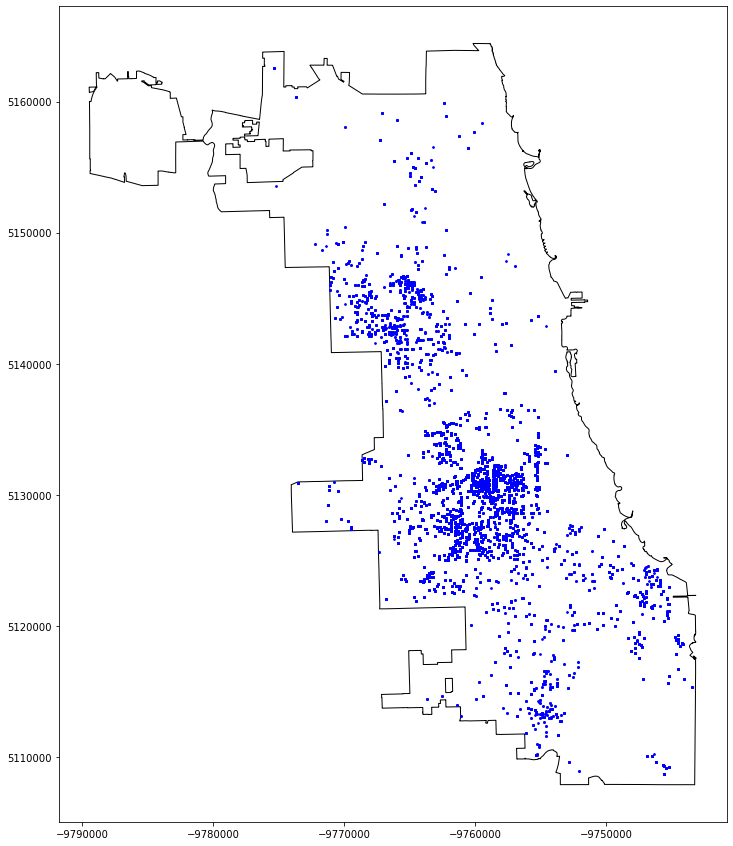

In [90]:
base = chicago.plot(color='white', edgecolor='black', figsize=(15,15))
vacant_in_chicago.plot(ax=base, markersize=3, color='blue')

In [93]:
vacant_in_chicago_unique = vacant_in_chicago.drop_duplicates(subset=['Property Address'])

In [95]:
vacant_in_chicago_unique.shape

(2378, 22)

In [96]:
shootings['meters_to_nearest_vacant_bldg'] = shootings['geometry'].apply(min_distance, args=(vacant_in_chicago_unique,))

The above function is pretty slow, as there are a lot of records in the vacant buildings DataFrame that have to be iterated through every loop. It's practically $\mathcal{O}(n^2)$ in time complexity, so I highly recommend trimming rows wherever possible. I probably should have only performed this calculation on unique addresses (about 2300) rather than all records in the vacant building sheet (about 21500). In fact, I stopped it and did that.

In [97]:
shootings.head()

,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,Ward,Community Area,Year,Updated On,Latitude,Longitude,geometry,min_dist_to_cta_stop,meters_to_nearest_cta_stop,meters_to_nearest_vacant_bldg
64305,JA486531,2017-10-26 11:05:00,041XX S MICHIGAN AVE,041A,BATTERY,AGGRAVATED: HANDGUN,ALLEY,True,False,213,002,3,38,2017,2019-06-04 16:01:14,41.819549,-87.623109,POINT (-9754159.890 5133986.946),384.959206,384.959206,687.570771
64320,JB496541,2018-10-30 16:59:00,040XX W 30TH ST,041A,BATTERY,AGGRAVATED: HANDGUN,SIDEWALK,True,False,1031,010,22,30,2018,2019-06-04 16:01:14,41.838706,-87.725954,POINT (-9765608.549 5136848.990),2271.229463,2271.229463,370.508738
64552,JA549380,2017-12-14 18:09:00,065XX S GREEN ST,041A,BATTERY,AGGRAVATED: HANDGUN,SIDEWALK,False,False,723,007,6,68,2017,2019-06-06 16:02:57,41.775378,-87.645890,POINT (-9756695.874 5127391.356),583.094284,583.094284,95.263151
64572,JC191684,2019-03-19 15:15:00,053XX S MARSHFIELD AVE,041A,BATTERY,AGGRAVATED: HANDGUN,STREET,True,False,932,009,16,61,2019,2019-06-06 16:02:57,41.797206,-87.665882,POINT (-9758921.399 5130650.158),2311.623666,2311.623666,95.845439
64680,JB333435,2018-07-03 11:15:00,106XX S LOWE AVE,041A,BATTERY,AGGRAVATED: HANDGUN,ALLEY,True,False,2233,022,34,49,2018,2019-06-07 15:58:09,41.700788,-87.639003,POINT (-9755929.154 5116263.727),3605.674525,3605.674525,566.169101


In [98]:
CSV_OUT_PATH = os.path.join('data', 'shootings_data_with_new_features.csv')
shootings.to_csv(CSV_OUT_PATH, index=False)